In [114]:

import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_boston, load_wine, load_breast_cancer
from sklearn.datasets import fetch_california_housing
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.feature_selection import mutual_info_classif, f_classif
import matplotlib.pyplot as plt
%matplotlib inline




In [64]:
def load_data(dataset):
    dataset_call = {
        'boston': load_boston, # regression
        'wine': load_wine, # classification
        'cali': fetch_california_housing,  # regression
        'breast_cancer': load_breast_cancer, # classification
    }
    dataset_files = {
        'pokemon': {'filename': 'pokemon.csv', 'target': 'is_legendary'}  # classification, https://www.kaggle.com/rounakbanik/pokemon
    }
    if dataset in dataset_call.keys():
        data = dataset_call[dataset]()
        y = data.target
        df = pd.DataFrame(data.data, columns=data.feature_names)
    else:
        df = pd.read_csv(dataset_files[dataset]['filename'])
        y = df[dataset_files[dataset]['target']].values
        df.drop(columns=dataset_files[dataset]['target'], inplace=True)
               
    X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.2, random_state=42)
    out_dict = {
        'y': y,
        'df': df,
        'x_train': X_train,
        'x_valid': X_valid,
        'y_train': y_train,
        'y_valid': y_valid
    }
    return out_dict
    
ds = {}
for d in ['boston', 'wine', 'cali', 'breast_cancer', 'pokemon']:
    ds[d] = load_data(d)


# Wrapper Method Examples

### Forward selection

In [35]:
# https://medium.com/analytics-vidhya/feature-selection-for-dimensionality-reduction-wrapper-method-9979fffd0166
dataset = 'boston'
k = 3
cv = 3
scoring = 'r2'

#FOR REGRESSION MODEL
feature_select = SequentialFeatureSelector(LinearRegression(),
                                           k_features=k,
                                           forward=True,
                                           floating=False,
                                           scoring=scoring,
                                           cv=cv)
feature_select.fit(ds[dataset]['x_train'], ds[dataset]['y_train'])
feature_select.k_feature_names_

('RM', 'PTRATIO', 'LSTAT')

In [44]:
#FOR CLASSIFICATION MODEL
dataset = 'wine' # 'breast_cancer'
k = 3
cv = 3
scoring='accuracy'
feature_select = SequentialFeatureSelector(LogisticRegression(multi_class='ovr', solver='newton-cg'),
                                           k_features=k,
                                           forward=True,
                                           floating=False,
                                           scoring=scoring,
                                           cv=cv)
feature_select.fit(ds[dataset]['x_train'], ds[dataset]['y_train'])
feature_select.k_feature_names_

('alcohol', 'ash', 'flavanoids')

### Backward selection

In [45]:
dataset = 'boston'
k = 3
cv = 3
scoring = 'r2'
#FOR REGRESSION MODEL
feature_select = SequentialFeatureSelector(LinearRegression(),
                                           k_features=k,
                                           forward=False,
                                           floating=False,
                                           scoring=scoring,
                                           cv=cv)
feature_select.fit(ds[dataset]['x_train'], ds[dataset]['y_train'])
feature_select.k_feature_names_

('RM', 'PTRATIO', 'LSTAT')

In [47]:
#FOR CLASSIFICATION MODEL
dataset = 'wine'
k = 3
cv = 3
scoring = 'accuracy'
feature_select = SequentialFeatureSelector(LogisticRegression(solver='newton-cg'),
                                           k_features=k,
                                           forward=False,
                                           floating=False,
                                           scoring=scoring,
                                           cv=cv)
feature_select.fit(ds[dataset]['x_train'], ds[dataset]['y_train'])
feature_select.k_feature_names_

('flavanoids', 'color_intensity', 'proline')

### Exhaustive selection

In [51]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
#FOR REGRESSION MODELS
dataset = 'boston'
min_features = 3
max_features = 6
cv = 5
scoring = 'r2'
feature_select = ExhaustiveFeatureSelector(LinearRegression(),             
                                           min_features=min_features,
                                           max_features=max_features,
                                           scoring=scoring,
                                           print_progress=False,
                                           cv=cv)
feature_select = feature_select.fit(ds[dataset]['x_train'], ds[dataset]['y_train'])
print(f'Best accuracy score: {feature_select.best_score_}') 
print(f'Best subset (indices): {feature_select.best_idx_}') 
print(f'Best subset (name): {feature_select.best_feature_names_}')

Best accuracy score: 0.7129187439595597
Best subset (indices): (4, 5, 7, 10, 11, 12)
Best subset (name): ('NOX', 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT')


In [55]:
#FOR CLASSIFICATION MODELS
dataset = 'breast_cancer'
min_features = 3
max_features = 4
scoring = 'accuracy'
cv = 2
feature_select = ExhaustiveFeatureSelector(LogisticRegression(max_iter=1000),             
                                           min_features=min_features,
                                           max_features=max_features,
                                           scoring=scoring,
                                           print_progress=False,
                                           cv=cv)
feature_select = feature_select.fit(ds[dataset]['x_train'], ds[dataset]['y_train'])
print(f'Best accuracy score: {feature_select.best_score_}') 
print(f'Best subset (indices): {feature_select.best_idx_}') 
print(f'Best subset (name): {feature_select.best_feature_names_}')

Best accuracy score: 0.9538314398330628
Best subset (indices): (10, 20, 21, 26)
Best subset (name): ('radius error', 'worst radius', 'worst texture', 'worst concavity')


In [ ]:
# Recursive Feature Selection
from sklearn.feature_selection import RFE
rfe = RFE(lr, n_features_to_select=7)
rfe.fit(x_train, y_train)
y_pred = rfe.predict(x_train)

# mRMR correlation example

In [130]:
# github.com/smazzanti/mrmr
dataset = 'boston'
K = 3

# inputs:
#    X: pandas.DataFrame, features
#    y: pandas.Series, target variable
#    K: number of features to select
X = ds[dataset]['x_train']
y = ds[dataset]['y_train']
# compute F-statistics and initialize correlation matrix
F = pd.Series(f_regression(ds[dataset]['x_train'], ds[dataset]['y_train'])[0], index = X.columns)
corr = pd.DataFrame(.00001, index=ds[dataset]['x_train'].columns, columns=ds[dataset]['x_train'].columns)

# initialize list of selected features and list of excluded features
selected = []
not_selected = ds[dataset]['x_train'].columns.to_list()

# repeat K times
for i in range(K):
  
    # compute (absolute) correlations between the last selected feature and all the (currently) excluded features
    if i > 0:
        last_selected = selected[-1]
        corr.loc[not_selected, last_selected] = X[not_selected].corrwith(X[last_selected]).abs().clip(.00001)
        
    # compute FCQ score for all the (currently) excluded features
    score = F.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001)
    
    # find best feature, add it to selected and remove it from not_selected
    best = score.index[score.argmax()]
    selected.append(best)
    not_selected.remove(best)
print(selected)

['LSTAT', 'RM', 'PTRATIO']


# F-test for classification and regression

### Regression

Feature 0: 67.883733
Feature 1: 42.588205
Feature 2: 114.320536
Feature 3: 15.161468
Feature 4: 84.013811
Feature 5: 410.229239
Feature 6: 52.621081
Feature 7: 23.522254
Feature 8: 71.013850
Feature 9: 107.771409
Feature 10: 127.844779
Feature 11: 52.516697
Feature 12: 476.339250


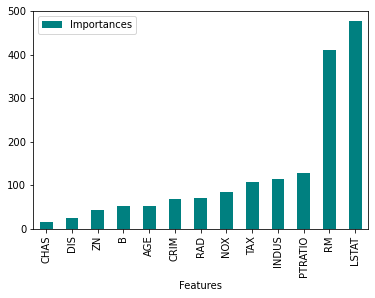

In [125]:
dataset = 'boston'
# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression


def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all')
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection
_, _, fs = select_features(ds[dataset]['x_train'], ds[dataset]['y_train'],ds[dataset]['x_valid'])
final_df = pd.DataFrame({ "Features": pd.DataFrame(ds[dataset]['x_train']).columns, "Importances": fs.scores_})
final_df.set_index('Importances')
# sort in ascending order to better visualization.
final_df = final_df.sort_values('Importances')
# plot the feature importances in bars.
final_df.plot.bar(color='teal', x='Features')
# what are scores for the feature
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))


### Classification

# Mutual Information for classification and regression

### Regression

Feature 0: 0.338664
Feature 1: 0.179428
Feature 2: 0.476692
Feature 3: 0.014828
Feature 4: 0.438236
Feature 5: 0.508649
Feature 6: 0.297733
Feature 7: 0.261638
Feature 8: 0.223895
Feature 9: 0.339232
Feature 10: 0.480366
Feature 11: 0.174690
Feature 12: 0.671884


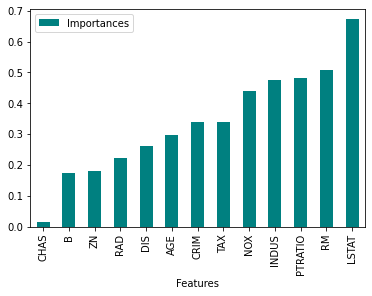

In [146]:
dataset = 'boston'

# example of mutual information feature selection for numerical input data
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=mutual_info_regression, k='all')
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# If you want to create your own dataset
# X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)
# split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# feature selection
_, _, fs = select_features(ds[dataset]['x_train'], ds[dataset]['y_train'],ds[dataset]['x_valid'])

final_df = pd.DataFrame({ "Features": pd.DataFrame(ds[dataset]['x_train']).columns, \
                         "Importances": fs.scores_, "Included": fs.get_support()})
final_df.set_index('Importances')
# sort in ascending order to better visualization.
final_df = final_df.sort_values('Importances')
# plot the feature importances in bars.
final_df.plot.bar(color='teal', x='Features')
# what are scores for the feature
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

### Classification

Feature worst concavity: 0.315260
Feature mean radius: 0.325420
Feature mean area: 0.341036
Feature mean concavity: 0.354883
Feature mean perimeter: 0.384964
Feature worst radius: 0.433926
Feature worst concave points: 0.434384
Feature mean concave points: 0.435989
Feature worst area: 0.439824
Feature worst perimeter: 0.468578


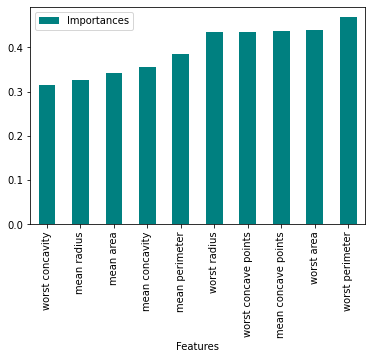

In [147]:
dataset = 'breast_cancer'
from sklearn.preprocessing import LabelEncoder
#importances = mutual_info_classif(ds[dataset]['x_train'], y_train_enc)
#feat_importances = pd.Series(importances, dataframe.columns[@:len(dataframe.columns)-1])
#feat_importances.plot(kind='barh', color = 'teal')
#plt.show()

 
# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc
 
def select_features(X_train, y_train, X_test):
    # configure to select 10 features
    fs = SelectKBest(score_func=mutual_info_classif, k=10)
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# prepare output data
y_train_enc, y_test_enc = prepare_targets(ds[dataset]['y_train'], ds[dataset]['y_valid'])

_, _, fs = select_features(ds[dataset]['x_train'], y_train_enc, ds[dataset]['x_valid'])
# print(fs.get_support())
final_df = pd.DataFrame({ "Features": pd.DataFrame(ds[dataset]['x_train']).columns, 
                         "Importances": fs.scores_, "Included": fs.get_support()})
final_df.set_index('Importances')
# sort in ascending order to better visualization.
final_df = final_df[final_df.Included == True].sort_values('Importances')
# plot the feature importances in bars.
final_df.plot.bar(color='teal', x='Features')
# what are scores for the feature
for _, row in final_df.iterrows():
    print('Feature %s: %f' % (row['Features'], row['Importances']))

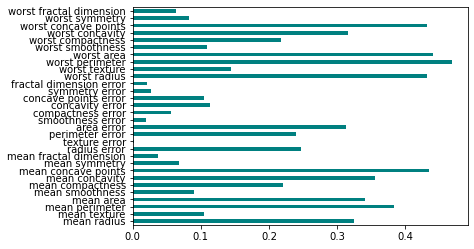

In [140]:
importances = mutual_info_classif(ds[dataset]['x_train'], y_train_enc)
feat_importances = pd.Series(importances, ds[dataset]['x_train'].columns[0:len(ds[dataset]['x_train'].columns)])
feat_importances.plot(kind='barh', color = 'teal')
plt.show()

# Feature importances from embedded methods

### Random Forest

In [82]:
# !head pokemon.csv

/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/pandas/core/frame.py:4321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


             Features  Importances
17      against_water     0.001204
3    against_electric     0.001467
12     against_normal     0.001803
15       against_rock     0.002030
10     against_ground     0.002778
6        against_fire     0.002993
7      against_flying     0.003217
11        against_ice     0.003286
1        against_dark     0.003413
9       against_grass     0.003487
13     against_poison     0.003524
0         against_bug     0.003721
2      against_dragon     0.004021
16      against_steel     0.004035
14    against_psychic     0.004314
4       against_fairy     0.005048
5       against_fight     0.008566
32         generation     0.008686
8       against_ghost     0.008832
22            defense     0.013802
29         sp_defense     0.022216
18             attack     0.022851
31          weight_kg     0.026797
30              speed     0.027061
25                 hp     0.030148
28          sp_attack     0.031945
24           height_m     0.033096
23  experience_growt

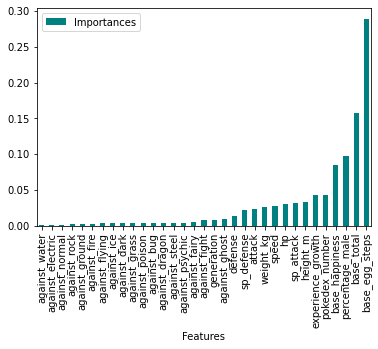

In [87]:
# create the random forest with your hyperparameters.

#### NOTE: I have not cleaned this dataset, and it has some nans and such in it.  You should try cleaning it :)  I have just removed
# some stuff to show you how the RFC works.
d = 'pokemon'
# drop the columns that are not numerical for this:
# numerics = ['int16','int32','int64','float16','float32','float64']
# numerical_vars = list(data.select_dtypes(include=numerics).columns)
# data = data[numerical_vars]
ds[d]['x_train'].fillna(1, inplace=True)  # note, the weight has some nans in it
x_train = ds[d]['x_train'].drop(columns=['abilities', 'name', 'type1', 'type2', 'japanese_name', 'classfication', 'capture_rate'])

model = RandomForestClassifier(n_estimators=250, random_state=42, max_depth=10)
# fit the model to start training.
model.fit(x_train, ds[d]['y_train'])
# get the importance of the resulting features.
importances = model.feature_importances_
# create a data frame for visualization.
final_df = pd.DataFrame({ "Features": pd.DataFrame(x_train).columns, "Importances": importances})
final_df.set_index('Importances')
# sort in ascending order to better visualization.
final_df = final_df.sort_values('Importances')
# plot the feature importances in bars.
final_df.plot.bar(color='teal', x='Features')
print(final_df)

### L1 Regularisation

In [112]:
dataset = 'breast_cancer'
# Set the regularization parameter C=1
logistic = LogisticRegression(C=1, penalty="l1", solver='liblinear', random_state=7)
model = SelectFromModel(logistic)  # this chooses the best features for us!
model.fit(ds[dataset]['x_train'], ds[dataset]['y_train'])
# model.

selected_feat = ds[dataset]['x_train'].columns[(model.get_support())]
print('total features: {}'.format((ds[dataset]['x_train'].shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(model.estimator_.coef_ == 0)))
print(selected_feat)

total features: 30
selected features: 10
features with coefficients shrank to zero: 20
Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'texture error', 'area error', 'worst texture', 'worst perimeter',
       'worst area', 'worst concavity'],
      dtype='object')


/opt/homebrew/Caskroom/miniforge/base/envs/py3c/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


   Features  Importances
2     INDUS     0.000000
3      CHAS     0.000000
4       NOX     0.000000
11        B     0.011181
9       TAX     0.012286
6       AGE     0.016395
1        ZN     0.028501
0      CRIM     0.076609
8       RAD     0.219654
7       DIS     0.630858
10  PTRATIO     0.708582
12    LSTAT     0.747107
5        RM     1.630489


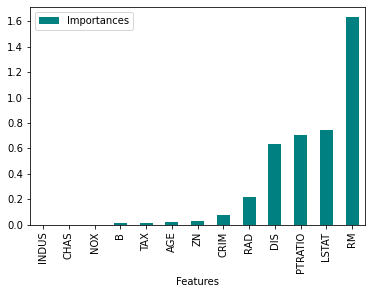

In [107]:
from sklearn.linear_model import Lasso
import numpy as np
dataset = 'boston'
# Set the regularization parameter C=1
lasso = Lasso(random_state=7)
lasso.fit(ds[dataset]['x_train'], ds[dataset]['y_train'])
# coef_lasso_ = np.array([lasso.coef_ for y in ds[dataset]['y_train'].T])
importances = np.abs(lasso.coef_)
final_df = pd.DataFrame({ "Features": pd.DataFrame(ds[dataset]['x_train']).columns, "Importances": importances})
final_df.set_index('Importances')
# sort in ascending order to better visualization.
final_df = final_df.sort_values('Importances')
# plot the feature importances in bars.
final_df.plot.bar(color='teal', x='Features')
print(final_df)
# now we just have to choose which ones to keep... top 5? Top 3?

# Simple Filter

### Variance threshold

In [ ]:
from sklearn.feature_selection import VarianceThreshold
# Resetting the value of X to make it non-categorical
X = array[:,0:8]
v_threshold = VarianceThreshold(threshold=0)
v_threshold.fit(X) # fit finds the features with zero variance
v_threshold.get_support()

### Correlation threshold